In [3]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import load_iris
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import plotly.graph_objs as go
import plotly.offline as py
# from bayes_opt import BayesianOptimization
import shap

py.init_notebook_mode(connected=True)

In [4]:
sample_data = pd.read_csv("sample.csv")
print(sample_data.info(verbose=True, show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124615 entries, 0 to 124614
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   co2         124615 non-null  int64  
 1   temp        124615 non-null  float64
 2   humid       124615 non-null  float64
 3   csd         124615 non-null  int64  
 4   sound       124615 non-null  int64  
 5   state       124615 non-null  object 
 6   age         124615 non-null  int64  
 7   gender      124615 non-null  object 
 8   height      124615 non-null  int64  
 9   weight      124615 non-null  int64  
 10  disease     124615 non-null  object 
 11  depressive  124615 non-null  int64  
 12  disorder    124615 non-null  object 
 13  media       124615 non-null  int64  
 14  liquor      124615 non-null  int64  
 15  smoke       124615 non-null  int64  
 16  caffeine    124615 non-null  int64  
 17  exercise    124615 non-null  int64  
 18  stress      124615 non-null  int64  
 19  na

In [9]:
sample_data = remove_outliers(sample_data, "co2", 0.05, 0.95)
idx_zero_temp = sample_data[sample_data['temp'] == 0].index
sample_data = sample_data.drop(idx_zero_temp)
sample_data.info(verbose=True, show_counts=True)

sample_data = pd.get_dummies(sample_data)                       # Embedding

# Train - Test Split
x_data = sample_data.iloc[:, 6:]
y_data = sample_data.iloc[:, [1, 2, 3, 4, 5]]
train_x, valid_x, train_y, valid_y = train_test_split(x_data, y_data, test_size=0.2, shuffle=True, random_state=1)

112556/124615 data points remain.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 111672 entries, 0 to 124614
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   co2         111672 non-null  int64  
 1   temp        111672 non-null  float64
 2   humid       111672 non-null  float64
 3   csd         111672 non-null  int64  
 4   sound       111672 non-null  int64  
 5   state       111672 non-null  object 
 6   age         111672 non-null  int64  
 7   gender      111672 non-null  object 
 8   height      111672 non-null  int64  
 9   weight      111672 non-null  int64  
 10  disease     111672 non-null  object 
 11  depressive  111672 non-null  int64  
 12  disorder    111672 non-null  object 
 13  media       111672 non-null  int64  
 14  liquor      111672 non-null  int64  
 15  smoke       111672 non-null  int64  
 16  caffeine    111672 non-null  int64  
 17  exercise    111672 non-null  int64  
 18  stress    

In [8]:
def remove_outliers(df, column_name, lower, upper):
    removed_outliers = df[column_name].between(df[column_name].quantile(lower), df[column_name].quantile(upper))

    print(str(df[column_name][removed_outliers].size) + "/" + str(sample_data[column_name].size) + " data points remain.")

    index_names = df[~removed_outliers].index
    return df.drop(index_names)


def PlotMultiplePie(df, categorical_features=None, dropna=False):
    # set a threshold of 30 unique variables, more than 50 can lead to ugly pie charts
    threshold = 30

    # if user did not set categorical_features
    if categorical_features is None:
        categorical_features = df.select_dtypes(['object', 'category']).columns.to_list()

    print("The Categorical Features are:", categorical_features)

    # loop through the list of categorical_features
    for cat_feature in categorical_features:
        num_unique = df[cat_feature].nunique(dropna=dropna)
        num_missing = df[cat_feature].isna().sum()
        # prints pie chart and info if unique values below threshold
        if num_unique <= threshold:
            print('Pie Chart for: ', cat_feature)
            print('Number of Unique Values: ', num_unique)
            print('Number of Missing Values: ', num_missing)
            fig = px.pie(df[cat_feature].value_counts(dropna=dropna), values=cat_feature,
                         names=df[cat_feature].value_counts(dropna=dropna).index, title=cat_feature, template='ggplot2')
            fig.show()
        else:
            print('Pie Chart for ', cat_feature, ' is unavailable due high number of Unique Values ')
            print('Number of Unique Values: ', num_unique)
            print('Number of Missing Values: ', num_missing)
            print('\n')


def evaluateRegressor(true, predicted, message="    Test Set"):
    MSE = mean_squared_error(true, predicted, squared=True)
    MAE = mean_absolute_error(true, predicted)
    RMSE = mean_squared_error(true, predicted, squared=False)
    R_squared = r2_score(true, predicted)

    print(message)
    print("MSE :", MSE)
    print("MAE :", MAE)
    print("RMSE :", RMSE)
    print("R-Squared :", R_squared)
    
    
def evaluateKFold(model):
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, x_data, y_data, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    rmse = np.sqrt(-1*n_scores)
    print('RMSE: %.3f'%np.mean(rmse))
    

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='stress', ylabel='count'>

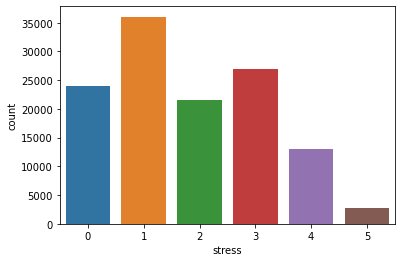

In [10]:
sample_data = pd.read_csv("sample.csv")
idx_zero_temp = sample_data[sample_data['stress'] == -1].index
sample_data = sample_data.drop(idx_zero_temp)
sns.countplot(sample_data['stress'])
# sns.countplot(sample_data['age'])
# sns.countplot(sample_data['weight'])
# sns.countplot(sample_data['height'])
# sns.countplot(sample_data['media'])
# sns.countplot(sample_data['liquor'])
# sns.countplot(sample_data['smoke'])
# sns.countplot(sample_data['caffeine'])
# sns.countplot(sample_data['exercise'])
# sns.countplot(sample_data['stress'])

In [11]:
sample_data = pd.read_csv("sample.csv")
sample_data = remove_outliers(sample_data, "co2", 0.05, 0.95)
idx_zero_temp = sample_data[sample_data['temp'] == 0].index
sample_data = sample_data.drop(idx_zero_temp)
idx_zero_temp = sample_data[sample_data['stress'] == -1].index
sample_data = sample_data.drop(idx_zero_temp)
sample_data.info(verbose=True, show_counts=True)

sample_data = pd.get_dummies(sample_data)                       # Embedding
x_data = sample_data.iloc[:, 5:]
y_data = sample_data.iloc[:, [0, 1, 2, 3, 4]]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=42)
# x_data.info(verbose=True, show_counts=True)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)
y_train_scaled = sc.fit_transform(y_train)
y_test_scaled = sc.transform(y_test)

x_train_scaled = np.array(x_train_scaled, dtype=np.float32)
y_train_scaled = np.array(y_train_scaled, dtype=np.float32)
x_test_scaled = np.array(x_test_scaled, dtype=np.float32)
y_test_scaled = np.array(y_test_scaled, dtype=np.float32)

inputs = x_train_scaled
targets = y_train_scaled
test_inputs = x_test_scaled
test_targets = y_test_scaled


112556/124615 data points remain.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 111440 entries, 0 to 124614
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   co2         111440 non-null  int64  
 1   temp        111440 non-null  float64
 2   humid       111440 non-null  float64
 3   csd         111440 non-null  int64  
 4   sound       111440 non-null  int64  
 5   state       111440 non-null  object 
 6   age         111440 non-null  int64  
 7   gender      111440 non-null  object 
 8   height      111440 non-null  int64  
 9   weight      111440 non-null  int64  
 10  disease     111440 non-null  object 
 11  depressive  111440 non-null  int64  
 12  disorder    111440 non-null  object 
 13  media       111440 non-null  int64  
 14  liquor      111440 non-null  int64  
 15  smoke       111440 non-null  int64  
 16  caffeine    111440 non-null  int64  
 17  exercise    111440 non-null  int64  
 18  stress    

In [12]:
print("Random Forest Regressor")
RFRegModel = RandomForestRegressor(random_state=0).fit(inputs, targets)
predict_train_y = RFRegModel.predict(inputs)
evaluateRegressor(targets, predict_train_y, "    Training Set")
predict_valid_y = RFRegModel.predict(test_inputs)
evaluateRegressor(test_targets, predict_valid_y)
predict_valid_y = sc.inverse_transform(predict_valid_y)
evaluateRegressor(y_test, predict_valid_y,"    Valid Set")

Random Forest Regressor
    Training Set
MSE : 0.2224043078598903
MAE : 0.24640288274712924
RMSE : 0.46415873333917707
R-Squared : 0.7775956923240173
    Test Set
MSE : 0.22351010648321434
MAE : 0.24804689934420546
RMSE : 0.46478271311327823
R-Squared : 0.7781252701467214
    Valid Set
MSE : 31743.39743907359
MAE : 53.15134703081998
RMSE : 84.52600071159752
R-Squared : 0.7781252710409555


In [ ]:
features = x_train.columns.values
x, y = (list(x) for x in zip(*sorted(zip(RFRegModel.feature_importances_, features),reverse=False)) )

trace = go.Bar(x=x,y=y,
              marker=dict(
              color=x,
              colorscale = 'Viridis',
              reversescale = True),
              name = 'Random Forest Feature importance',
              orientation='h',
              )
layout = dict(title='Feature Importance', 
              width = 900, 
              height = 900, 
              yaxis=dict(showgrid=False, showline=False, showticklabels=True,domain=[0,0.85],)
             )

fig = go.Figure(data=[trace])
fig['layout'].update(layout)
py.iplot(fig, filename='plots')

In [ ]:
print("Linear Regression")
LinearModel = LinearRegression().fit(inputs, targets)
predict_train_y = LinearModel.predict(inputs)
evaluateRegressor(targets, predict_train_y, "    Training Set")
predict_valid_y = LinearModel.predict(test_inputs)
evaluateRegressor(test_targets, predict_valid_y)
predict_valid_y = sc.inverse_transform(predict_valid_y)
evaluateRegressor(y_test, predict_valid_y,"    Valid Set")

In [13]:
print("Decision Tree")
DTModel = DecisionTreeRegressor().fit(inputs, targets)
predict_train_y = DTModel.predict(inputs)
evaluateRegressor(targets, predict_train_y, "    Training Set")
predict_valid_y = DTModel.predict(test_inputs)
evaluateRegressor(test_targets, predict_valid_y)
predict_valid_y = sc.inverse_transform(predict_valid_y)
evaluateRegressor(y_test, predict_valid_y,"    Valid Set")

Decision Tree
    Training Set
MSE : 0.2223926533893265
MAE : 0.24638659536934124
RMSE : 0.46414641759782815
R-Squared : 0.7776073467945472
    Test Set
MSE : 0.2235142047447683
MAE : 0.24802731326232327
RMSE : 0.464792667453812
R-Squared : 0.7781214025082306
    Valid Set
MSE : 31736.65249736671
MAE : 53.14122115834918
RMSE : 84.51813238257583
R-Squared : 0.7781214034010702


In [13]:
print("K-Nearest Neighbors")
KNNModel = KNeighborsRegressor().fit(inputs, targets)
predict_train_y = KNNModel.predict(inputs)
evaluateRegressor(targets, predict_train_y, "    Training Set")
predict_valid_y = KNNModel.predict(test_inputs)
evaluateRegressor(test_targets, predict_valid_y)
predict_valid_y = sc.inverse_transform(predict_valid_y)
evaluateRegressor(y_test, predict_valid_y,"    Valid Set")

K-Nearest Neighbors
    Training Set
MSE : 0.26929623
MAE : 0.25620085
RMSE : 0.510919
R-Squared : 0.7306991709487931
    Test Set
MSE : 0.26129922
MAE : 0.2561133
RMSE : 0.50244135
R-Squared : 0.7406224120824391
    Valid Set
MSE : 37700.429758644656
MAE : 55.8117810817961
RMSE : 92.01748304431183
R-Squared : 0.7406224152103545


In [14]:
print("Support Vector Machine - Direct Multioutput")
model = LinearSVR(C=0.1, random_state=1,max_iter=10000000)
model = MultiOutputRegressor(model)
model.fit(inputs, targets)
predict_train_y = model.predict(inputs)
evaluateRegressor(targets, predict_train_y, "    Training Set")
predict_valid_y = model.predict(test_inputs)
evaluateRegressor(test_targets, predict_valid_y)
predict_valid_y = sc.inverse_transform(predict_valid_y)
evaluateRegressor(y_test, predict_valid_y,"    Valid Set")

Support Vector Machine - Direct Multioutput
    Training Set
MSE : 0.8309530346653832
MAE : 0.5512184543843774
RMSE : 0.9089808540222757
R-Squared : 0.1690469621231045
    Test Set
MSE : 0.8366070094552469
MAE : 0.554300332485741
RMSE : 0.9124416249087732
R-Squared : 0.1672620674897093
    Valid Set
MSE : 164104.89465884928
MAE : 148.72528627686341
RMSE : 191.8108825832216
R-Squared : 0.16726206057462


In [15]:
print("Support Vector Machine - Chained Multioutput")
model = LinearSVR(C=0.1, random_state=1,max_iter=10000000)
model = RegressorChain(model)
model.fit(inputs, targets)
predict_train_y = model.predict(inputs)
evaluateRegressor(targets, predict_train_y, "    Training Set")
predict_valid_y = model.predict(test_inputs)
evaluateRegressor(test_targets, predict_valid_y)
predict_valid_y = sc.inverse_transform(predict_valid_y)
evaluateRegressor(y_test, predict_valid_y,"    Valid Set")

Support Vector Machine - Chained Multioutput
    Training Set
MSE : 0.8300299100200398
MAE : 0.5522820189701337
RMSE : 0.9083979399667689
R-Squared : 0.16997008676515163
    Test Set
MSE : 0.8358087189462928
MAE : 0.5552767597127879
RMSE : 0.9119353709890075
R-Squared : 0.16803217403089016
    Valid Set
MSE : 164104.8830685694
MAE : 148.73224054428496
RMSE : 191.80931817165316
R-Squared : 0.1680321671489113


In [14]:
sample_data = pd.read_csv("sample.csv")
sample_data = remove_outliers(sample_data, "co2", 0.05, 0.95)
idx_zero_temp = sample_data[sample_data['temp'] == 0].index
sample_data = sample_data.drop(idx_zero_temp)
idx_zero_temp = sample_data[sample_data['stress'] == -1].index
sample_data = sample_data.drop(idx_zero_temp)
sample_data.info(verbose=True, show_counts=True)

sample_data = pd.get_dummies(sample_data)                       # Embedding
x_data = sample_data.iloc[:, 5:]
y_data = sample_data.iloc[:, [0, 1, 2, 3, 4]]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=42)
# x_data.info(verbose=True, show_counts=True)

sc_x = MinMaxScaler()
sc_y = MinMaxScaler()
x_train_scaled = sc_x.fit_transform(x_train)
x_test_scaled = sc_x.transform(x_test)
y_train_scaled = sc_y.fit_transform(y_train)
y_test_scaled = sc_y.transform(y_test)

x_train_scaled = np.array(x_train_scaled, dtype=np.float32)
y_train_scaled = np.array(y_train_scaled, dtype=np.float32)
x_test_scaled = np.array(x_test_scaled, dtype=np.float32)
y_test_scaled = np.array(y_test_scaled, dtype=np.float32)

inputs = x_train_scaled
targets = y_train_scaled
test_inputs = x_test_scaled
test_targets = y_test_scaled


112556/124615 data points remain.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 111440 entries, 0 to 124614
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   co2         111440 non-null  int64  
 1   temp        111440 non-null  float64
 2   humid       111440 non-null  float64
 3   csd         111440 non-null  int64  
 4   sound       111440 non-null  int64  
 5   state       111440 non-null  object 
 6   age         111440 non-null  int64  
 7   gender      111440 non-null  object 
 8   height      111440 non-null  int64  
 9   weight      111440 non-null  int64  
 10  disease     111440 non-null  object 
 11  depressive  111440 non-null  int64  
 12  disorder    111440 non-null  object 
 13  media       111440 non-null  int64  
 14  liquor      111440 non-null  int64  
 15  smoke       111440 non-null  int64  
 16  caffeine    111440 non-null  int64  
 17  exercise    111440 non-null  int64  
 18  stress    

In [117]:
print("Linear Regression")
LinearModel = LinearRegression().fit(inputs, targets)
predict_train_y = LinearModel.predict(inputs)
evaluateRegressor(targets, predict_train_y, "    Training Set")
predict_valid_y = LinearModel.predict(test_inputs)
evaluateRegressor(test_targets, predict_valid_y)
predict_valid_y = sc_y.inverse_transform(predict_valid_y)
evaluateRegressor(y_test, predict_valid_y,"    Valid Set")

Linear Regression
    Training Set
MSE : 0.020501312
MAE : 0.096236125
RMSE : 0.12977155
R-Squared : 0.23700155240632528
    Test Set
MSE : 0.020489972
MAE : 0.09650255
RMSE : 0.13006714
R-Squared : 0.23473029753501082
    Valid Set
MSE : 160965.82336490118
MAE : 151.87362707907093
RMSE : 189.33706616109956
R-Squared : 0.23473030276202983


In [15]:
print("Decision Tree")
DTModel = DecisionTreeRegressor().fit(inputs, targets)
predict_train_y = DTModel.predict(inputs)
evaluateRegressor(targets, predict_train_y, "    Training Set")
predict_valid_y = DTModel.predict(test_inputs)
evaluateRegressor(test_targets, predict_valid_y)
predict_valid_y = sc_y.inverse_transform(predict_valid_y)
evaluateRegressor(y_test, predict_valid_y,"    Valid Set")

Decision Tree
    Training Set
MSE : 0.00534427045615798
MAE : 0.03908274385369785
RMSE : 0.0679030561040054
R-Squared : 0.7776073461816339
    Test Set
MSE : 0.005367163265596608
MAE : 0.03938383199601976
RMSE : 0.06802216098550301
R-Squared : 0.7781214041498753
    Valid Set
MSE : 31736.652494908496
MAE : 53.14122112611047
RMSE : 84.51813238177401
R-Squared : 0.7781214032566199


In [33]:
features = x_train.columns.values
x, y = (list(x) for x in zip(*sorted(zip(DTModel.feature_importances_, features),reverse=False)) )

trace = go.Bar(x=x,y=y,
              marker=dict(
              color=x,
              colorscale = 'Viridis',
              reversescale = True),
              name = 'Decision Tree Feature importance',
              orientation='h',
              )
layout = dict(title='Feature Importance', 
              width = 900, 
              height = 900, 
              yaxis=dict(showgrid=False, showline=False, showticklabels=True,domain=[0,0.85],)
             )

fig = go.Figure(data=[trace])
fig['layout'].update(layout)
py.iplot(fig, filename='plots')

In [27]:
print("K-Nearest Neighbors")
KNNModel = KNeighborsRegressor().fit(inputs, targets)
predict_train_y = KNNModel.predict(inputs)
evaluateRegressor(targets, predict_train_y, "    Training Set")
predict_valid_y = KNNModel.predict(test_inputs)
evaluateRegressor(test_targets, predict_valid_y)
predict_valid_y = sc.inverse_transform(predict_valid_y)
evaluateRegressor(y_test, predict_valid_y,"    Valid Set")

K-Nearest Neighbors
    Training Set
MSE : 0.0034465645
MAE : 0.029542621
RMSE : 0.053878594
R-Squared : 0.7339901165115871
    Test Set
MSE : 0.0034578845
MAE : 0.029620945
RMSE : 0.05406647
R-Squared : 0.7331042936051652
    Valid Set
MSE : 36899.42969971419
MAE : 55.505192602944305
RMSE : 91.08390186066579
R-Squared : 0.7331042995847353


In [28]:
print("Random Forest Regressor")
RFRegModel = RandomForestRegressor(random_state=0).fit(inputs, targets)
predict_train_y = RFRegModel.predict(inputs)
evaluateRegressor(targets, predict_train_y, "    Training Set")
predict_valid_y = RFRegModel.predict(test_inputs)
evaluateRegressor(test_targets, predict_valid_y)
predict_valid_y = sc.inverse_transform(predict_valid_y)
evaluateRegressor(y_test, predict_valid_y,"    Valid Set")

Random Forest Regressor
    Training Set
MSE : 0.002904936435404841
MAE : 0.02792942514787894
RMSE : 0.04947548399535896
R-Squared : 0.7775956652271497
    Test Set
MSE : 0.002914134912559272
MAE : 0.028140308815782465
RMSE : 0.049532564774521434
R-Squared : 0.7781252670702166
    Valid Set
MSE : 31743.397420131612
MAE : 53.15134694743362
RMSE : 84.52600069028708
R-Squared : 0.7781252707405482


In [29]:
print("Support Vector Machine - Direct Multioutput")
model = LinearSVR(C=0.1, random_state=1,max_iter=10000000)
model = MultiOutputRegressor(model)
model.fit(inputs, targets)
predict_train_y = model.predict(inputs)
evaluateRegressor(targets, predict_train_y, "    Training Set")
predict_valid_y = model.predict(test_inputs)
evaluateRegressor(test_targets, predict_valid_y)
predict_valid_y = sc.inverse_transform(predict_valid_y)
evaluateRegressor(y_test, predict_valid_y,"    Valid Set")

Support Vector Machine - Direct Multioutput
    Training Set
MSE : 0.012394242337778968
MAE : 0.06616696753394938
RMSE : 0.0992998425119185
R-Squared : 0.16934442929508925
    Test Set
MSE : 0.012328847264055079
MAE : 0.0662484071726479
RMSE : 0.0993777924370641
R-Squared : 0.16756093785217258
    Valid Set
MSE : 163551.69235195572
MAE : 148.7393295834323
RMSE : 191.5058606510473
R-Squared : 0.16756093801931157


In [30]:
print("Support Vector Machine - Chained Multioutput")
model = LinearSVR(C=0.1, random_state=1,max_iter=10000000)
model = RegressorChain(model)
model.fit(inputs, targets)
predict_train_y = model.predict(inputs)
evaluateRegressor(targets, predict_train_y, "    Training Set")
predict_valid_y = model.predict(test_inputs)
evaluateRegressor(test_targets, predict_valid_y)
predict_valid_y = sc.inverse_transform(predict_valid_y)
evaluateRegressor(y_test, predict_valid_y,"    Valid Set")

Support Vector Machine - Chained Multioutput
    Training Set
MSE : 0.012390157484789395
MAE : 0.06625819648967013
RMSE : 0.09925848496281639
R-Squared : 0.1703509643295721
    Test Set
MSE : 0.012325976933494966
MAE : 0.06633153630799898
RMSE : 0.09934416963048044
R-Squared : 0.1684006738168062
    Valid Set
MSE : 163551.695605601
MAE : 148.74555857726932
RMSE : 191.50499992606788
R-Squared : 0.16840067356594526


In [22]:
def predictEnvironment(model):
    people_data = pd.read_csv("real_validation.csv")
    print(" -- Input Raw Data -- ")
    print(people_data.iloc[:,5:])
    
    input_raw_data = pd.get_dummies(people_data)            # 임베딩
    input_raw_data = input_raw_data .iloc[:, 5:]            # 환경 데이터 제거
    input_raw_data.to_csv('real_input.csv', index=False)
    # scaler = MinMaxScaler()                                 # Scale Method
    input_data = sc_x.fit_transform(input_raw_data)       # 입력 값 설정
    input_data = np.array(input_data, dtype=np.float32)
    
    output_data = model.predict(input_data)             # 최적 수면 환경 예측
    output_data = sc_y.inverse_transform(output_data)
    print(" -- 최적 수면 환경 조언 (마지막은 2개는 더미) -- ")
    print("CO2농도  /  온도  /  습도  /  조도  /  소음")
    np.set_printoptions(precision=2, suppress=True)
    print(np.round(output_data,2))
    

In [23]:
predictEnvironment(DTModel)

 -- Input Raw Data -- 
     state  age  gender  height  weight       disease  depressive disorder  \
0   asleep   29    male     171      65          none           0       no   
1   asleep   28    male     170      70          none           0      yes   
2   asleep   28    male     172      67          none           0       no   
3   asleep   29    male     175      65          none           0       no   
4   asleep   28  female     158      45          none           3      yes   
5   asleep   27    male     175      75          none           0       no   
6   asleep   30    male     174      83          none           0      yes   
7   asleep   31  female     161      63          none           1      yes   
8   asleep   30    male     163      68          none           0       no   
9   asleep   42    male     175      95          none           0       no   
10  asleep   33  female     168      60          none           1       no   
11  asleep   31  female     170      78  